In [115]:
import datetime
import sys
from datetime import datetime
from typing import List

from tqdm import tqdm
from utils.forecast import get_dwd_forecast

sys.path.append("/".join(sys.path[0].split("/")[:-1]))

import time
from enum import Enum
from typing import Callable, Dict, Iterable, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec

from studies.utils.forecast import get_dwd_forecast
from studies.utils.recent import get_recent

df = get_dwd_forecast(feature="precipitationTotal")
df.head()

,Unnamed: 0,call_time,station_id,provider,time,precipitationTotal
0,0,2023-12-11 00:10:01,Q811,DWD_1,2023-12-10 23:00:00,5
1,1,2023-12-11 00:10:01,Q811,DWD_1,2023-12-11 00:00:00,3
2,2,2023-12-11 00:10:01,Q811,DWD_1,2023-12-11 01:00:00,3
3,3,2023-12-11 00:10:01,Q811,DWD_1,2023-12-11 02:00:00,3
4,4,2023-12-11 00:10:01,Q811,DWD_1,2023-12-11 03:00:00,2


In [116]:
import logging


class Feature(Enum):
    PRECIPITATION = 1
    TEMPERATURE = 2


FORECAST_FEATURE_TRANSLATOR = {
    Feature.PRECIPITATION: ("precipitationTotal", "precipitation_forecast")
}
RECENT_FEATURE_TRANSLATOR = {
    Feature.PRECIPITATION: ("precipitation", "precipitation_real")
}


class DWD_Dataset:
    def __init__(self, source_path: str, feature: Feature):
        # load station meta information
        self._stations = pd.read_csv(source_path + "/stations.tsv", sep="\t")

        forecast_feature_name, forecast_column_name = FORECAST_FEATURE_TRANSLATOR[
            feature
        ]
        # get forecast
        self._forecast = get_dwd_forecast(forecast_feature_name, source_path)
        # drop unnamed colum
        self._forecast = self._forecast.drop(columns="Unnamed: 0")
        # rename forecast_column
        self._forecast = self._forecast.rename(
            columns={forecast_feature_name: forecast_column_name}
        )
        # filter for measurement errors
        # convert kennungen to real ids
        # huge speedup to turn the data-structure in the lightweight dict
        kennung_id_dict = dict(
            zip(self._stations["Stations-kennung"], self._stations["Stations_ID"])
        )
        self._forecast["station_id"] = self._forecast["station_id"].apply(
            kennung_id_dict.__getitem__
        )

        # get recent
        property, recent_column_name = RECENT_FEATURE_TRANSLATOR[feature]
        self._real_data = get_recent(feature=property)
        # clean columns
        self._real_data = self._real_data.drop(
            columns=["QN_8", "RS_IND", "WRTR", "eor"]
        )
        # rename columns
        self._real_data = self._real_data.rename(
            columns={
                "MESS_DATUM": "time",
                "  R1": recent_column_name,
                "STATIONS_ID": "station_id",
            }
        )
        # clean data by removing every point which is outside every forecast
        min_time = min(self._forecast["time"])
        self._real_data = self._real_data[self._real_data["time"] >= min_time]
        # ... and also vise versa on forecasts we can't evaluate because we don't have a reference
        max_time = max(self._real_data["time"])
        self._forecast = self._forecast[self._forecast["time"] <= max_time]

        
        # create a merge dataset where we link forecasts and recent data
        self._merge = pd.merge(
            self._forecast, self._real_data, on=["time", "station_id"], how="left"
        )
        # add difference
        self._merge.insert(
            len(self._merge.columns),
            "error",
            self._merge["precipitation_forecast"] - self._merge["precipitation_real"],
        )
        
        # TODO: correct this. ASSIGNING 0 TO MEASUREMENT ERRORS IS PURELY WRONG
    
        
    def get_forecast(self, station_id: int = 0, model: int = 0):
        forecast = self._filter_df(self._forecast, station_id, model)
        return forecast

    def get_merge(self, station_id: int = 0, model: int = 0):
        merge = self._filter_df(self._merge, station_id, model)
        return merge

    def get_real_data(self, station_id: int = 0, model: int = 0):
        real_data = self._filter_df(self._real_data, station_id, model)
        return real_data
    
    def get_matrix(self, data_column: str):
        if data_column not in self._merge.columns:
            logging.error(f"{data_column} not in {self._merge.columns}. Not possible to create matrix")
            return
        errors = []
        merge = self._merge[self._merge["provider"] == "DWD_1"]
        station_ids = merge["station_id"].unique()
        for call_time in sorted(merge["call_time"].unique()):
            same_call_time = merge[merge["call_time"] == call_time]
            call_time_errors = []
            for station_id in station_ids:
                call_time_error = same_call_time[same_call_time["station_id"] == station_id]["error"].values
                # This is a HACK and needs to be resolved
                # THIS ONLY WORKS FOR MODEL 1
                call_time_error = call_time_error[:72]
                if len(call_time_error) < 72:
                    continue
                call_time_errors.append(call_time_error)
            if len(call_time_errors):
                errors.append(np.stack(call_time_errors))

        # shape: (num_api_calls, num_stations, num_predictions_into_future)
        errors = np.stack(errors)
        return errors
        
    
    def _filter_errors(self, threshold: float = 900):
        """_summary_

        Args:
            threshold (float, optional): disable it with values > 999. Defaults to 900.
        """
        # find mistakes in forecasts
        mask_1 = self._forecast["precipitation_forecast"].abs() > threshold 
        mask_2 = self._real_data["precipitation_real"].abs() > threshold 
        mask = mask_1 & mask_2

        print(len())
        self._forecast = self._forecast[mask]
        self._real_data = self._real_data[mask]
        self._merge = self._merge[mask]

    @staticmethod
    def _filter_df(df: pd.DataFrame, station_id: int = 0, model: int = 0):
        if station_id > 0:
            df = df[df["station_id"] == station_id]

        if "provider" not in df.columns:
            pass
        elif model > 2 or model < 0:
            raise ValueError(
                "Choose either model 1 or 2. If you want to obtain both: 0"
            )
        else:
            df = df[df["provider"] == f"DWD_{model}"]
            df = df.drop(columns=["provider"])

        return df




dataset = DWD_Dataset(source_path="../data/dwd", feature=Feature.PRECIPITATION)

First look at one specific station

In [117]:
STATION_ID = 257

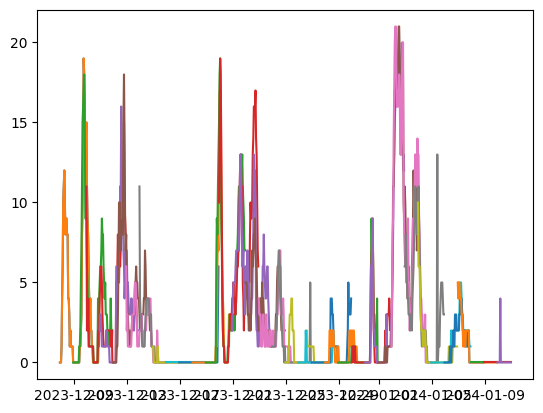

In [118]:
forecast = dataset.get_forecast(model=1, station_id=STATION_ID)


fig, ax = plt.subplots()
for call_time in sorted(forecast["call_time"].unique()):
    sub_df = forecast[forecast["call_time"] == call_time]
    t = sub_df["time"]
    values = sub_df["precipitation_forecast"]
    ax.plot(t, values)

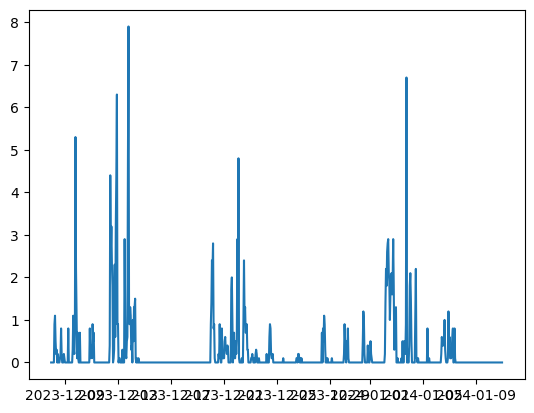

In [119]:
real_data = dataset.get_real_data(model=1, station_id=STATION_ID)


fig, ax = plt.subplots()
ax.plot(real_data["time"], real_data["precipitation_real"])

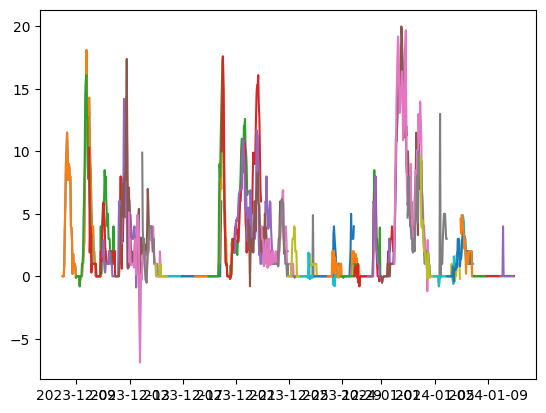

In [120]:
merge = dataset.get_merge(model=1, station_id=STATION_ID)


fig, ax = plt.subplots()
for call_time in sorted(merge["call_time"].unique()):
    sub_df = merge[merge["call_time"] == call_time]
    t = sub_df["time"]
    error = sub_df["error"]
    ax.plot(t, error)

Do a permutation test for the whole error.  
H0: The forecast is not prone to overestimate nor underestimate precipitation 

In [121]:
from random import shuffle


merge = dataset.get_merge(model=1)

mean_error = merge["error"].mean()
# concatenate real values as forecasts
concat = np.concatenate([merge["precipitation_forecast"], merge["precipitation_real"]])
shuffle(concat)
shuffle_error = concat[:len(merge)] - concat[len(merge):]

Significance level of mean error= 1.395313810376482 = 0.09511774972234188


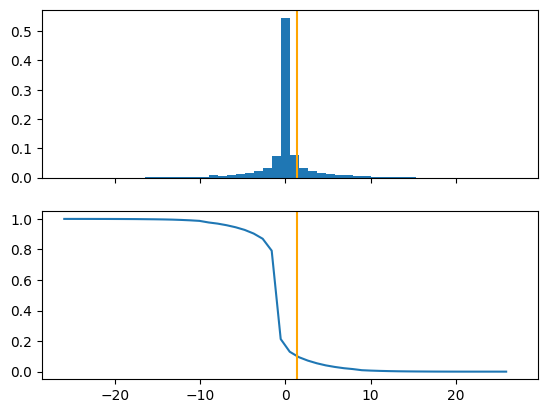

In [122]:
fig, axs = plt.subplots(nrows=2, sharex=True)
# TODO: how many bins????
count, bins, _ = axs[0].hist(shuffle_error, bins=50, density=True)
axs[0].axvline(mean_error, c="orange")
cdf = np.cumsum(count) / count.sum()
axs[1].plot(bins[:-1], 1 - cdf)
axs[1].axvline(mean_error, c="orange")

# calculate significance level
index = np.argmax((bins - mean_error) > 0)
print(f"Significance level of mean error= {mean_error} = {(1 - cdf)[index]}")


What is the general trend of the error in  model 1

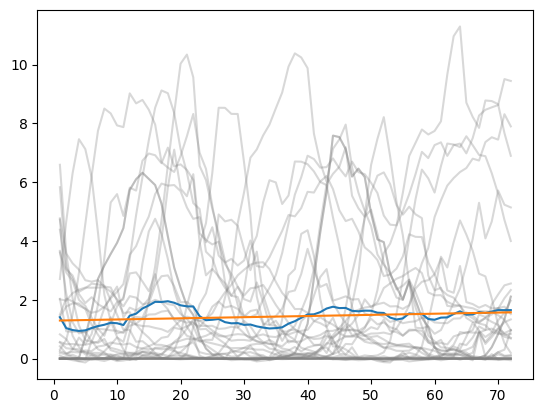

In [123]:
# transform list of errors into a 3d matrix
error_matrix = dataset.get_matrix("error")

fig, ax = plt.subplots()
station_errors = error_matrix.mean(axis=1)

x_axis = np.arange(1, 73)

ax.plot(x_axis, station_errors.T, label="station mean error", color="grey", alpha=0.3)
forecast_error = station_errors.mean(axis=0)
ax.plot(x_axis, forecast_error)

# extract trend
x = np.arange(0, 72)
x_aug = np.concatenate
x = np.arange(72)[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
covariance = x_aug.T @ x_aug
coef = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T @ forecast_error
regression = x_aug @ coef

ax.plot(x_axis, regression)

get confidence intervalls of the mean curve (blue) with bootstrap

In [135]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 100000

error_matrix = dataset.get_matrix("error")

flatten_errors = np.concatenate(error_matrix, axis=0)
N = len(flatten_errors)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means = []
for time_step_error in tqdm(flatten_errors.T):
    simulated_errors = np.random.choice(time_step_error, size=(N_BOOT, N), replace=True)
    boot_strap_means.append(simulated_errors.mean(axis=1))

boot_strap_means = np.stack(boot_strap_means)


 29%|██▉       | 21/72 [00:43<01:35,  1.87s/it]

(72, 10000)


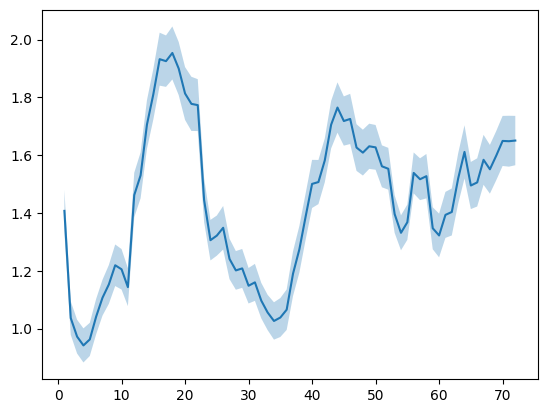

In [134]:
print(boot_strap_means.shape)

fig, ax = plt.subplots()
x_axis = np.arange(1, 73)
mean = boot_strap_means.mean(axis=1)
std = boot_strap_means.std(axis=1)
ax.plot(x_axis, mean)
ax.fill_between(x_axis, mean - std, mean + std, alpha=0.3)

# TODO: ellipse plots???? 

In [ ]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1,height_ratios=[5,1])
ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0], sharex=ax1)
axs = [ax0, ax1]

min_time = datetime(9999, 1, 1, 0, 0)
max_time = datetime(1, 1, 1, 0)
for call_time in sorted(q811["call_time"].unique())[1:]:
    api_call = q811[q811["call_time"] == call_time]
    
    sorted_df = api_call[["time", "precipitationTotal"]].sort_values(by=["time"])
    # print(sorted_df)
    axs[0].plot(sorted_df["time"], sorted_df["precipitationTotal"], alpha=0.3)
    left = min(sorted_df["time"])
    right = max(sorted_df["time"])
    axs[1].plot((left, right), (call_time, call_time))

    if left < min_time:
        min_time = left
    if right > max_time:
        max_time = right

plt.setp(ax0.get_xticklabels(), visible=False)
day_labels = [dt._text.split(" ")[0] for dt in axs[1].get_xticklabels()[::24]]
axs[1].set_xticks(axs[1].get_xticks()[::24], day_labels, rotation=90)

axs[0].set_ylabel("Predicted total precipitation")
axs[1].set_xlabel("Forecast for time")
axs[1].set_ylabel("Time of forecast")

print(min_time, max_time)

In [ ]:
hourly = df[df["provider"] == "DWD_1"]
q811 = hourly[hourly["station_id"] == "Q811"]



fig = plt.figure()
gs = gridspec.GridSpec(2, 1,height_ratios=[5,1])
ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0], sharex=ax1)
axs = [ax0, ax1]

min_time = datetime(9999, 1, 1, 0, 0)
max_time = datetime(1, 1, 1, 0)
for call_time in sorted(q811["call_time"].unique())[1:]:
    api_call = q811[q811["call_time"] == call_time]
    
    sorted_df = api_call[["time", "precipitationTotal"]].sort_values(by=["time"])
    # print(sorted_df)
    axs[0].plot(sorted_df["time"], sorted_df["precipitationTotal"], alpha=0.3)
    left = min(sorted_df["time"])
    right = max(sorted_df["time"])
    axs[1].plot((left, right), (call_time, call_time))

    if left < min_time:
        min_time = left
    if right > max_time:
        max_time = right

plt.setp(ax0.get_xticklabels(), visible=False)
day_labels = [dt._text.split(" ")[0] for dt in axs[1].get_xticklabels()[::24]]
axs[1].set_xticks(axs[1].get_xticks()[::24], day_labels, rotation=90)

axs[0].set_ylabel("Predicted total precipitation")
axs[1].set_xlabel("Forecast for time")
axs[1].set_ylabel("Time of forecast")

print(min_time, max_time)

NameError: name 'df' is not defined

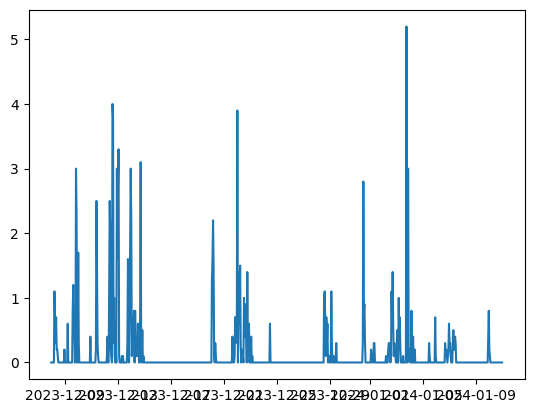

In [ ]:
# find station id to Stationskennung Q811
import pandas as pd

from studies.utils.recent import get_recent
from project.process.utils.download_dwd_data import FEATURE_STATION_PROPERTY_MAP
import glob

stations_df = pd.read_csv("../data/dwd/stations.tsv", sep="\t")

station_id = stations_df[stations_df["Stations-kennung"] == "Q811"]["Stations_ID"].unique()[0]


# load real data for station_id
property = "precipitation"
recent_df = get_recent(feature=property)
recent_df = recent_df.rename(columns={"MESS_DATUM": "time"})
recent_df = recent_df[recent_df["STATIONS_ID"] == station_id]
recent_df = recent_df[["STATIONS_ID", "time", "  R1"]]
recent_df = recent_df[recent_df["time"] >= min_time]
recent_df = recent_df[recent_df["time"] <= max_time]

# plot recent precipitation
fig, ax = plt.subplots()
ax.plot(recent_df["time"], recent_df["  R1"])

Here I want ot calculate the errors of a prediction

In [ ]:
# load prediction
provider = "DWD_1"
station_id = "Q811"
feature = "precipitationTotal"

In [ ]:
forecasts = get_dwd_forecast(feature)
forecasts = forecasts[forecasts["provider"] == provider]
# forecasts = forecasts[forecasts["station_id"] == station_id]
recent = get_recent("precipitation")
stations = pd.read_csv("../data/dwd/stations.tsv", sep="\t")

def get_station_id(stations_kennung: str):
    station_id = list(stations[stations["Stations-kennung"] == stations_kennung]["Stations_ID"].unique())[0]
    return station_id

forecasts["station_id"] = forecasts["station_id"].apply(get_station_id)

In [ ]:
from studies.utils.forecast import set_errors_to_zeros


recent = recent.rename(columns={"MESS_DATUM": "time", "STATIONS_ID": "station_id"})
recent["  R1"] = recent["  R1"].apply(set_errors_to_zeros)
merge = pd.merge(forecasts, recent, on=["time", "station_id"], how="left")
merge = merge.assign(error=lambda x: x['precipitationTotal'] - x['  R1'])
# exclude station_id=1239
merge = merge[merge["station_id"] != 1239]

Text(0.5, 0, 'Datetime of comparison')

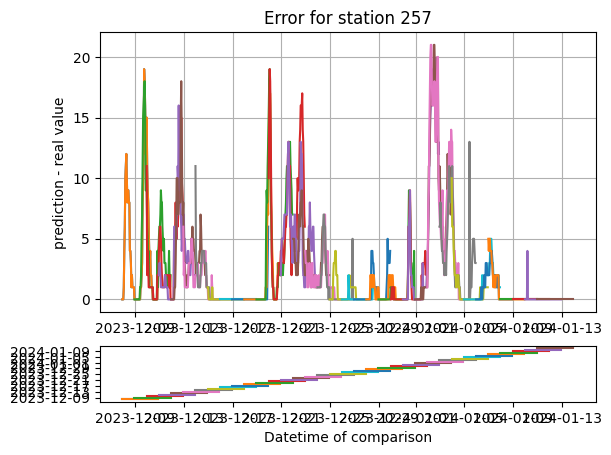

In [ ]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1,height_ratios=[5,1])
ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0], sharex=ax1)
axs = [ax0, ax1]

station_id = 257
axs[0].set_title(f"Error for station {station_id}")
for call_time in sorted(forecasts["call_time"].unique()):
    call_time_forecast = merge[(merge["call_time"] == call_time) & (merge["station_id"] == station_id)]
    forecast_time = call_time_forecast["time"]
    axs[0].plot(forecast_time, call_time_forecast["precipitationTotal"])
    axs[1].plot((min(forecast_time), max(forecast_time)), (call_time, call_time))

axs[0].grid()
axs[0].set_ylabel("prediction - real value")
axs[1].set_xlabel("Datetime of comparison")

We can obsever in this plot that the error is basically greater than zero. This means the forecast is more prone to predict more rain than in real life

In [ ]:
errors = []
station_ids = merge["station_id"].unique()

for call_time in sorted(merge["call_time"].unique()):
    same_call_time = merge[merge["call_time"] == call_time]
    call_time_errors = []
    for station_id in station_ids:
        call_time_error = same_call_time[same_call_time["station_id"] == station_id]["error"].values
        call_time_error = call_time_error[:72]  # This is a HACK and needs to be resolved
        call_time_errors.append(call_time_error)
    errors.append(np.stack(call_time_errors))
    time = same_call_time["time"].values 

# shape: (num_api_calls, num_stations, num_predictions_into_future)
errors = np.stack(errors)
num_errors_per_call_time = np.isnan(errors).sum(axis=2).sum(1)
print(num_errors_per_call_time)
# print(list(zip(merge["call_time"].unique(), num_errors_per_call_time)))
# errors = np.abs(errors)
# ax.plot(x, np.stack(errors).mean(axis=0))
"""fig, ax = plt.subplots()
for call_time_error in errors:
    for station_error in call_time_error:
        ax.plot(station_error, alpha=1/np.sqrt(len(errors) + len(call_time_error)), color="grey", label="individual station")
mean_error = np.concatenate(errors, axis=0).mean(axis=0) 
ax.plot(mean_error, label="mean")
ax.set_ylabel("predicted precipitation - real precipitation")
ax.set_xlabel("time steps into the future")"""

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  805 1645 2485]


'fig, ax = plt.subplots()\nfor call_time_error in errors:\n    for station_error in call_time_error:\n        ax.plot(station_error, alpha=1/np.sqrt(len(errors) + len(call_time_error)), color="grey", label="individual station")\nmean_error = np.concatenate(errors, axis=0).mean(axis=0) \nax.plot(mean_error, label="mean")\nax.set_ylabel("predicted precipitation - real precipitation")\nax.set_xlabel("time steps into the future")'

Do a permutation test for the whole error.  
H0: The forecast is not prone to overestimate nor underestimate precipitation 

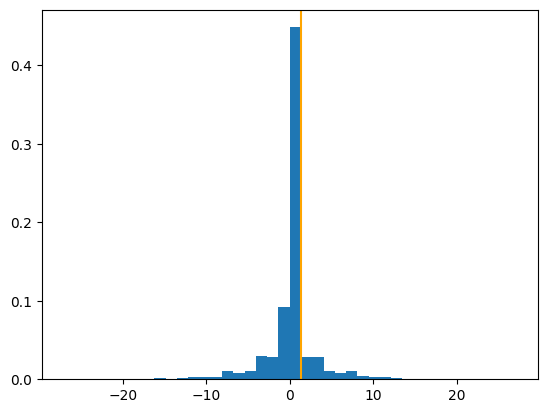

In [ ]:
from sklearn.utils import shuffle

prediction = merge["precipitationTotal"].values
real = merge["  R1"].values

# exclude nan values
mask = np.isnan(prediction) + np.isnan(real)
prediction = prediction[~mask]
real = real[~mask]
mean_error = (prediction - real).mean()

data = np.concatenate([prediction, real])
scrambled = shuffle(data)
scrambled = np.stack([scrambled[:len(prediction)], scrambled[len(prediction):]])
error = scrambled[0] - scrambled[1]

fig, ax = plt.subplots()
hist, bins = np.histogram(error, bins=40, density=True)
ax.hist(error, bins=40, density=True)
ax.axvline(mean_error, color="orange")


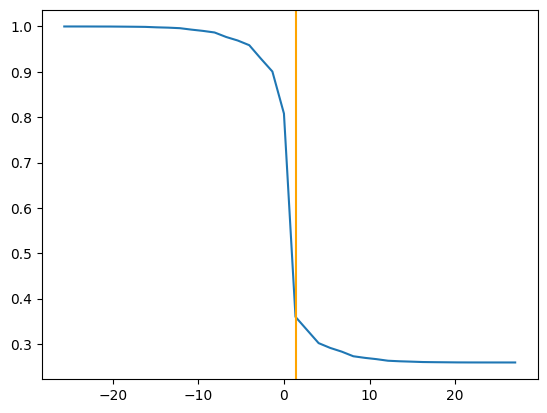

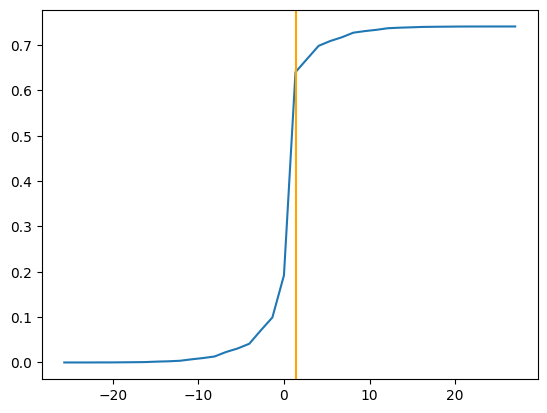

In [ ]:
fig, ax = plt.subplots()
ax.plot(bins[1:], 1- hist.cumsum())
ax.axvline(mean_error, color="orange")

fig, ax = plt.subplots()
ax.plot(bins[1:], hist.cumsum())
ax.axvline(mean_error, color="orange")


IS one location espacially prone for errors?


[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[[0]]
[[1 0]]


LinAlgError: Singular matrix

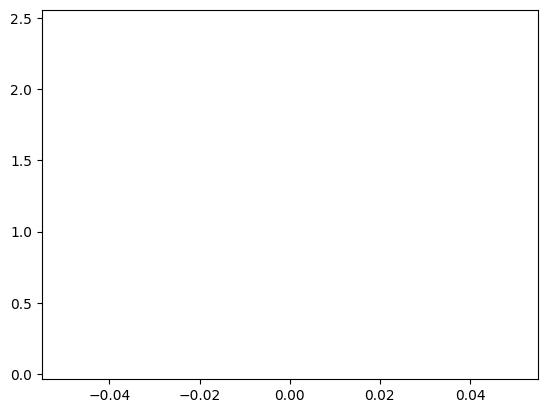

In [ ]:
errors = np.stack(errors)
fig, ax = plt.subplots()
for station_id, station_error in zip(station_ids, errors.swapaxes(0, 1)):
    ax.plot(np.mean(station_error, axis=0), c="gray", alpha=0.3)

ax.plot(np.mean(station_error, axis=0), c="gray", alpha=0.3, label="station mean error")

mean_error = errors.mean(axis=0)
mean_error = mean_error.mean(axis=0)
ax.plot(mean_error, label="meanerror")

# line fitting
mask = np.isnan(mean_error)
x = np.arange(72)[:, None][~mask]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
covariance = x_aug.T @ x_aug
coef = np.linalg.inv(x_aug.T @ x_aug) @x_aug.T @ mean_error[~mask]

fit = x_aug @ coef
ax.plot(x, fit, label="linear regression")
ax.legend()
ax.set_xlabel("prediction step into the future")
ax.set_ylabel("prediction - real")

In [ ]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 10000
N = len(flatten_errors)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means = []
for time_step_error in tqdm(errors.swapaxes(0, 2)):
    flatten_errors = time_step_error.flatten()
    simulated_errors = np.random.choice(flatten_errors, size=(N_BOOT, N), replace=True)
    boot_strap_means.append(simulated_errors.mean(axis=1))

boot_strap_means = np.stack(boot_strap_means)


100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


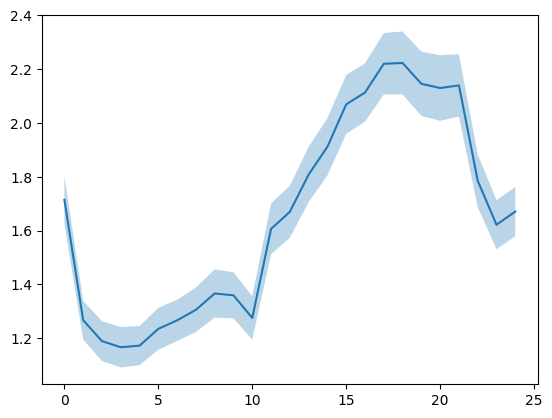

In [ ]:
fig, ax = plt.subplots()
stds = np.std(boot_strap_means, axis=1)

ax.plot(mean_error)
ax.fill_between(np.arange(72), mean_error - stds, mean_error + stds, alpha=0.3)

IS one location espacially prone for errors?

Compute correlation between error and time to forecast?
Can we observe the same thing for temperature?

Can we do somehow bootstrapping?


Compute on average divergence for a forecast into the future. 
Observer how a forecast changes over time

